# Многорукие бандиты

- Множество состояний $\mathcal{S}$ состоит из одного элемента: $|\mathcal{S}| = 1$, поэтому проблема credit assignment в данном случае не стоит.
- Множество действий $\mathcal{A} = \{1, 2, \ldots, M\}$ фиксированно.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Зададим генератор seed-ов для воспроизводимости кода

In [2]:
def seed_gen(seed=2025):
    rng = np.random.default_rng(2025)
    while True:
        yield rng.integers(2 ** 32)

seeds = seed_gen()
seeds, next(seeds)

(<generator object seed_gen at 0x728b66bfe110>, np.int64(1921882075))

Класс `bandit.MultiArmedBandit` позволяет моделировать многоруких бандитов

In [3]:
from bandit import MultiArmedBandit


bernoulli_bandit = MultiArmedBandit(distr_name="bernoulli", params=[0.9, 0.6], seed=next(seeds))
bernoulli_bandit

In [4]:
actions = [0, 1, 0, 0, 1]
rewards = [bernoulli_bandit.pull(a) for a in actions]
rewards

[0, 1, 1, 1, 1]

Можно определять бандитов с распределениями наград из различных семейств. Именование параметров соответствует `scipy.stats`

In [5]:
mixed_bandit = MultiArmedBandit(
    [
        ("bernoulli", {"p": 0.5}),
        ("binomial", {"n": 10, "p": 0.1}),
        ("norm", {"loc": 0.5, "scale": 1.0}),
        ("uniform", {}),
    ],
    seed=next(seeds)
)

mixed_bandit

In [6]:
actions = [0, 1, 2, 3]
rewards = [mixed_bandit.pull(a) for a in actions]
rewards

[0, 2, np.float64(2.748717420843048), np.float64(0.17269600218015468)]

Визуализируем распределения наград для двух простых бандитов.

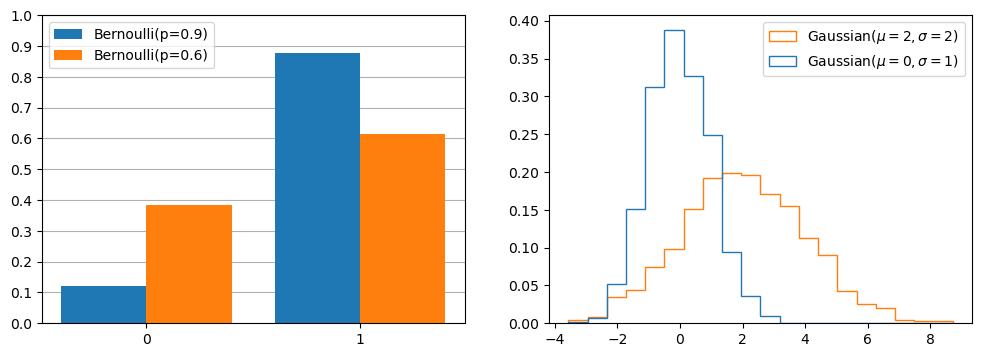

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

bernoulli_bandit = MultiArmedBandit(distr_name="bernoulli", params=[0.9, 0.6], seed=next(seeds))
gaussian_bandit = MultiArmedBandit(distr_name="gaussian", params=[[0, 1], [2, 2]], seed=next(seeds))

axs[0].hist(
    [[bernoulli_bandit.pull(0) for _ in range(1000)],
     [bernoulli_bandit.pull(1) for _ in range(1000)]],
    bins=[-0.5, 0.5, 1.5],
    density=True,
    label=["Bernoulli(p=0.9)", "Bernoulli(p=0.6)"],
)
axs[0].set_xticks([0, 1])
axs[0].set_ylim(0, 1)
axs[0].set_yticks(np.arange(0.0, 1.1, 0.1))
axs[0].set_axisbelow(True)
axs[0].grid(axis='y')
axs[1].hist(
    [[gaussian_bandit.pull(0) for _ in range(1000)],
     [gaussian_bandit.pull(1) for _ in range(1000)]],
    histtype='step',
    bins=20,
    density=True,
    label=["Gaussian($\mu=0, \sigma=1$)", "Gaussian($\mu=2, \sigma=2$)"]
)
axs[0].legend()
axs[1].legend()
plt.show()

## Жадные стратегии

Жадные стратегии начинают игру с небольшого исследования, дёргая каждую ручку несколько раз (параметр `exploring_start`) и накапливая статистику о наградах. После этого абсолютно жадная стратегия дёргает только ручки с наибольшей оценкой награды, продолжая накапливать статистику.

In [8]:
mab = MultiArmedBandit(distr_name="bernoulli", params=[0.6, 0.9], seed=next(seeds))
mab

In [9]:
from agent import Greedy
from manager import BanditsManager


manager = BanditsManager(
    environment=mab,
    agent=Greedy(2, exploring_start=2),
    n_rounds=20
)
results = manager.run()
results

{'agent_actions': array([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 'optimal_actions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'rewards': array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'optimal_rewards': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])}

In [10]:
results["rewards"].sum()

np.int64(16)

In [11]:
manager.agent.value_estimates

array([0.83333333, 0.5       ])

Серьёзный недостаток жадной стратегии в том, что при неудачном выпадении наград на этапе исследований, она рискует незаметить наиболее удачную ручку, и поэтому рискует всегда дёргать субоптимальные ручки.

Улучшением является $\varepsilon$-жадная стратегия. Её отличие в том, что на каждом шаге с вероятностью $\varepsilon$ стратегия будет делать исследование — дёргать за случайную ручку, а с вероятностью $(1 - \varepsilon)$ — использовать накопленные знания и дёргать за ручку с наибольшей оценкой ожидаемой награды, как это всегда делает жадная стратегия.

In [12]:
from agent import EpsilonGreedy


# В данном случае сравним успехи стратегий при абсолютно идентичном многоруком бандите
mab.reset(seed=mab.seed)

manager = BanditsManager(
    environment=mab,
    agent=EpsilonGreedy(2, epsilon=0.5, seed=next(seeds)),
    n_rounds=20
)
results = manager.run()
results

{'agent_actions': array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0]),
 'optimal_actions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'rewards': array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'optimal_rewards': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])}

In [13]:
results["rewards"].sum()

np.int64(16)

In [14]:
manager.agent.value_estimates

array([0.88888889, 0.72727273])

Полностью случайную стратегию можно считать частным случаем $\varepsilon$-жадной ($\varepsilon = 1$).

In [15]:
from agent import Random


mab.reset(seed=mab.seed)

manager = BanditsManager(
    environment=mab,
    agent=Random(2, seed=next(seeds)),
    n_rounds=20
)
results = manager.run()
results

{'agent_actions': array([1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0]),
 'optimal_actions': array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'rewards': array([1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]),
 'optimal_rewards': array([0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
        0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9])}

In [16]:
results["rewards"].sum()

np.int64(16)

In [17]:
manager.agent.value_estimates

array([0.63636364, 1.        ])

### Сравнение $\varepsilon$-жадных стратегий

По отдельным играм трудно сказать, какая стратегия лучше, поэтому посмотрим на эффективность стратегий в среднем, при большом числе игр.

In [18]:
from manager import get_average_performance


res = get_average_performance(
    MultiArmedBandit(distr_name="gaussian", params=[0.9, 0.6]),
    Greedy(2),
    n_rounds=2000,
    n_runs=100,
    threads=10,
)
res

{'average_rewards': array([0.86379247, 0.63756455, 0.86043081, ..., 0.99382635, 0.9181895 ,
        0.74821653], shape=(2000,)),
 'optimal_actions_rate': array([1.  , 0.  , 0.53, ..., 0.66, 0.66, 0.66], shape=(2000,)),
 'average_optimal_rewards': array([0.9, 0.9, 0.9, ..., 0.9, 0.9, 0.9], shape=(2000,))}

In [19]:
import matplotlib.ticker as mtick


def plot_performance_results(episodes_stats, labels):
    fig, axs = plt.subplots(1, 3, figsize=(20, 5))
    average_optimal_rewards = episodes_stats[0]["average_optimal_rewards"]

    for stats, label in zip(episodes_stats, labels):
        axs[0].plot(stats["optimal_actions_rate"] * 100)
        axs[1].plot(stats["average_rewards"])
        axs[2].plot(np.cumsum(stats["average_optimal_rewards"] - stats["average_rewards"]), label=label)
        
        assert np.allclose(average_optimal_rewards, stats["average_optimal_rewards"])
    
    axs[1].plot(average_optimal_rewards, label="Optimal reward")
    
    for ax in axs:
        ax.set_xlabel("Plays")
    axs[0].yaxis.set_major_formatter(mtick.PercentFormatter())
    axs[0].set_ylabel("Optimal actions")
    axs[1].set_ylabel("Average reward")
    axs[2].set_ylabel("Cumulative regret")
    axs[1].legend()
    axs[2].legend()
    return fig, axs

Определим многоруких бандитов, на которых будем производить сравнение

In [20]:
rng = np.random.default_rng(seed=next(seeds))

uniform_params = rng.normal(0, 10, size=(10, 2))
uniform_params.sort(axis=1)
uniform_params[:, 1] -= uniform_params[:, 0]

gaussian_params = rng.uniform(-5, 5, size=(10, 2))
gaussian_params[:, 1] = np.abs(gaussian_params[:, 1])

test_mabs = [
    (MultiArmedBandit(distr_name="bernoulli", params=[0.55, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45, 0.45]),
     "Bernoulli(ps=[0.55 x 1, 0.45 x 9])"),
    (MultiArmedBandit(distr_name="uniform", params=uniform_params),
     "Uniform x 10"),
    (MultiArmedBandit(distr_name="gaussian", params=gaussian_params),
     "Gaussian x 10")
]

Визуализираем распределение наград второго и третьего многоруких бандитов

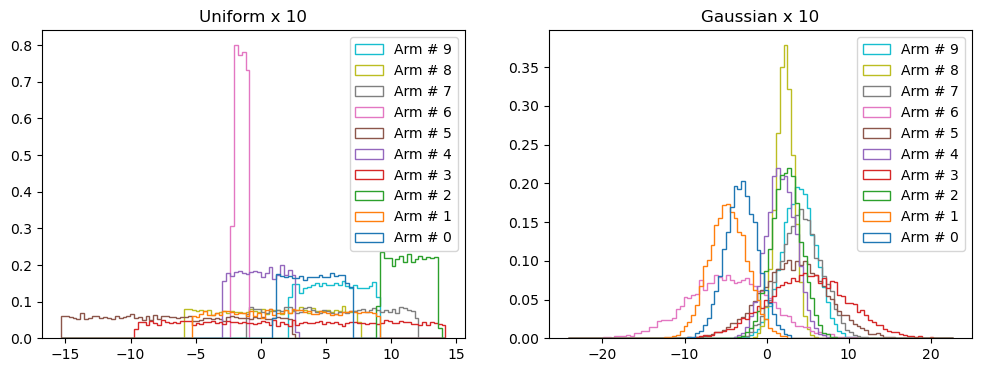

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

for i in range(2):
    mab, mab_desc = test_mabs[i + 1]
    axs[i].hist(
        [[mab.pull(j) for _ in range(10000)] for j in range(10)],
        bins=100,
        histtype='step',
        density=True,
        label=[f"Arm # {j}" for j in range(10)]
    )
    axs[i].legend()
    axs[i].set_title(mab_desc)

plt.show()

In [22]:
for mab, mab_desc in test_mabs:
    a_opt, r_exp = mab.optimal_action_reward
    print(mab_desc)
    print(f"    optimal arm: {a_opt}, expected_reward: {r_exp:.2f}")
    print()

Bernoulli(ps=[0.55 x 1, 0.45 x 9])
    optimal arm: 0, expected_reward: 0.55

Uniform x 10
    optimal arm: 2, expected_reward: 11.31

Gaussian x 10
    optimal arm: 3, expected_reward: 4.97



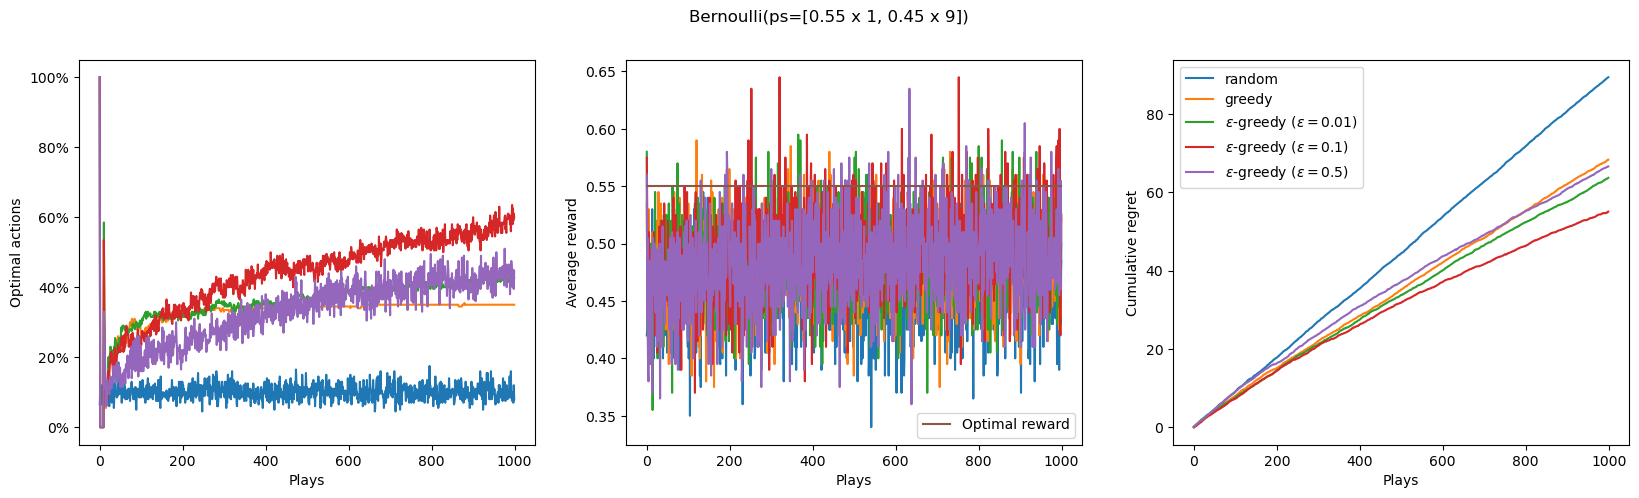

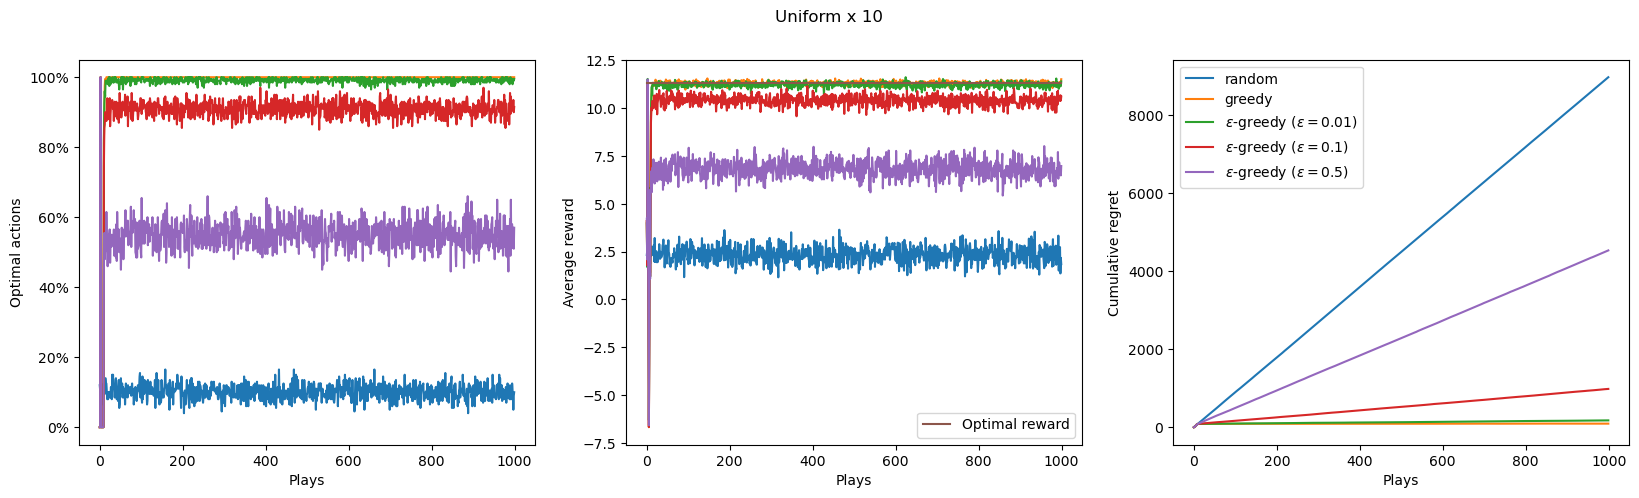

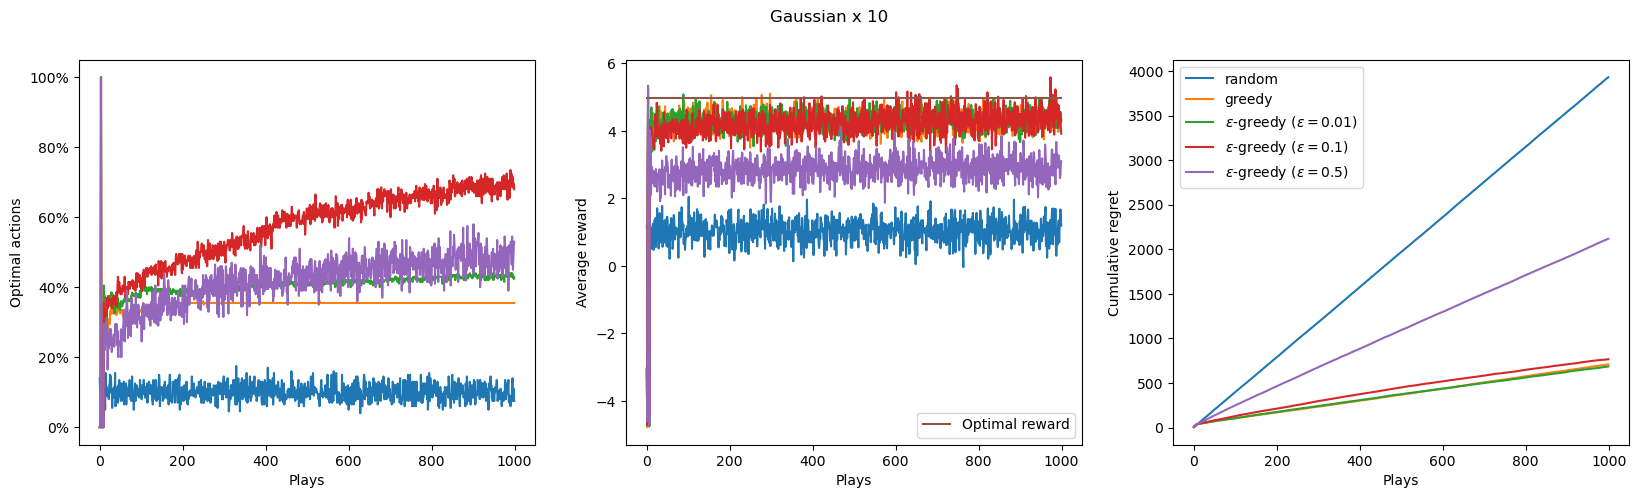

In [23]:
bench_kwargs = {
    "n_rounds": 1000,
    "n_runs": 200,
    "threads": 10,
}

agents = [
    Random(10),
    Greedy(10),
    EpsilonGreedy(10, 0.01),
    EpsilonGreedy(10, 0.1),
    EpsilonGreedy(10, 0.5),
]

labels = [
    "random",
    "greedy",
    r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
    r"$\varepsilon$-greedy ($\varepsilon = 0.1$)",
    r"$\varepsilon$-greedy ($\varepsilon = 0.5$)",
]

for mab, title in test_mabs:
    fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
    fig.suptitle(title)
    plt.show()

**Выводы:**

1. Очевидно, случайная стратегия никак не учитывает знания о получаемых наградах, поэтому она выбирает правильную ручку с вероятностью $\frac{1}{M}$. Её средняя награда есть среднее средних наград всех ручек, а цена обучения (regret) линейна по числу раундов. В дальнейшем не будем её рассматривать.
2. Выбор $\varepsilon$ для $\varepsilon$-жадных стратегий влияет на их результативность. Чем больше $\varepsilon$, тем ближе стратегия к случайной.

### $\varepsilon_n$-жадные стратегии

Серьёзный, но устранимый недостаток $\varepsilon$-жадных стратегий заключается в том, что они по определению будут выбирать неоптимальную ручку с вероятностью $\frac{M - 1}{M}\varepsilon$ вне зависимости от накопленного опыта, а потому их цена обучения (regret) будет линейна по числу раундов. Одним из возможных решений этой проблемы являются $\varepsilon_n$-жадные стратегии, т.е. это те же $\varepsilon$-жадные стратегии, но $\varepsilon$ уменьшается со временем (разумно сделать $\varepsilon_n \to 0$).

Возникает вопрос, как быстро должно убывать $\varepsilon_n$? Легко видеть, что ожидаемое число "исследовательских" действий равно $$\sum_{n = 1}^{\infty} \varepsilon_n$$
Если эта сумма конечна, то оценки ожидаемых выигрышей не будут сходиться к истинным значениям.

С другой стороны, хотелось бы, чтобы доля субоптимальных действий стремилась к нулю (иначе regret всё ещё будет линейным):
$$\frac1n \sum_{n = 1}^{\infty} \varepsilon_n \to 0$$

С первого взгляда, кажется разумным выбрать $\varepsilon_n \propto \frac1n$.

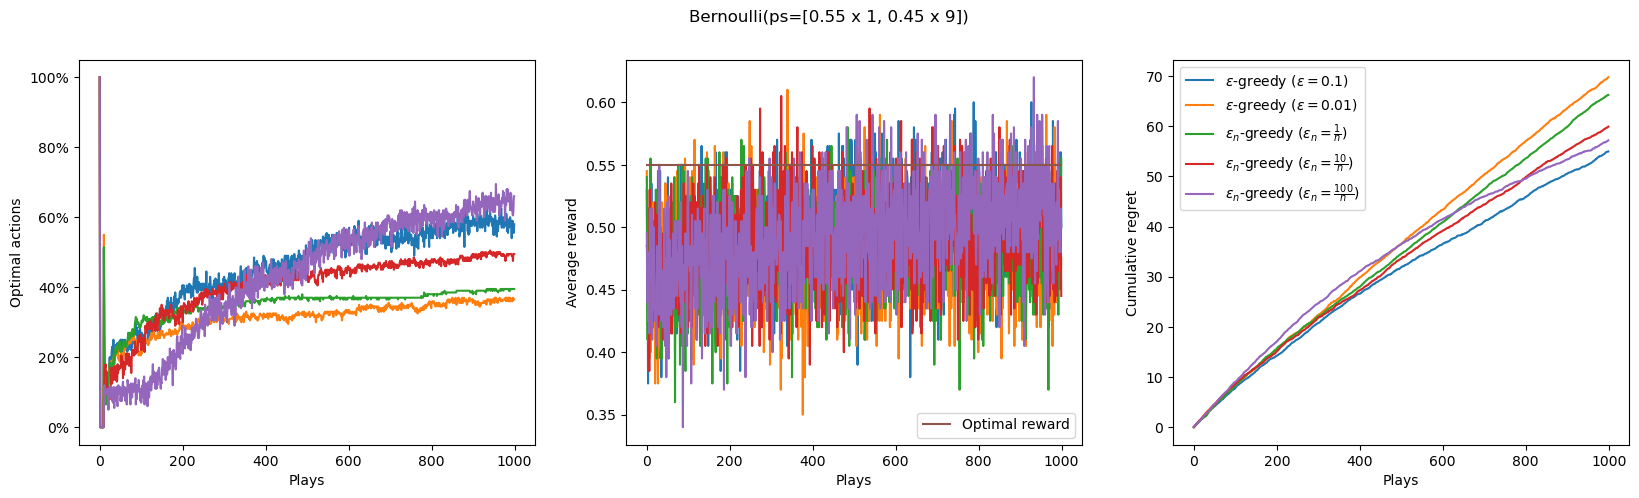

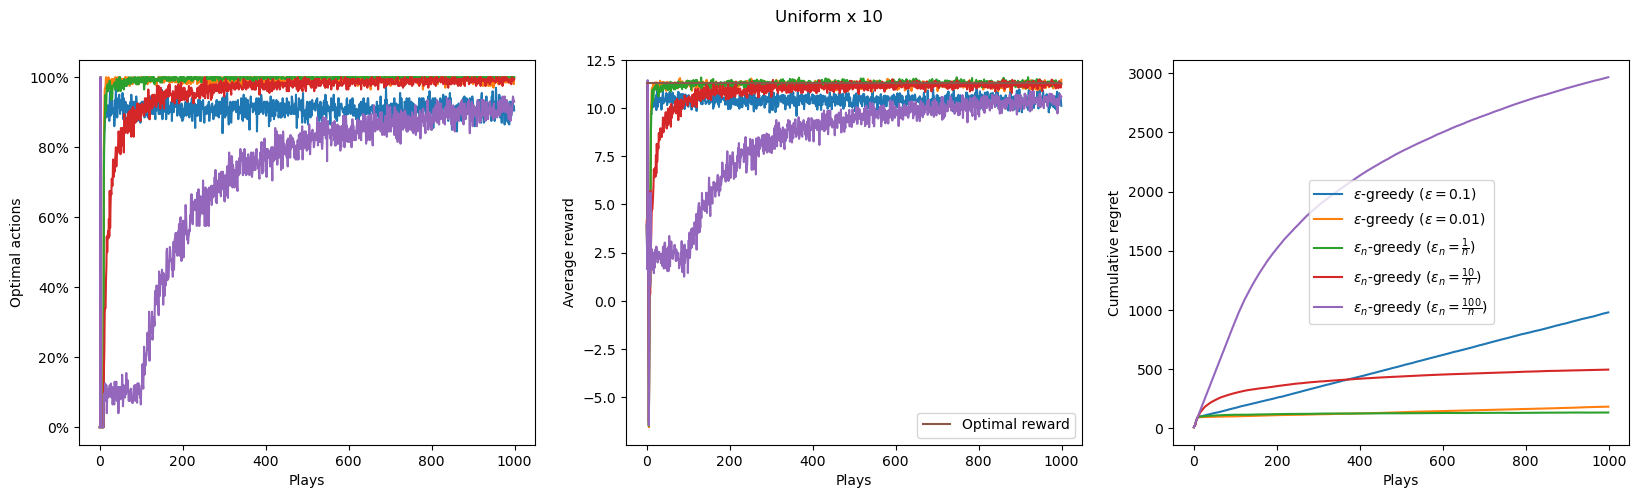

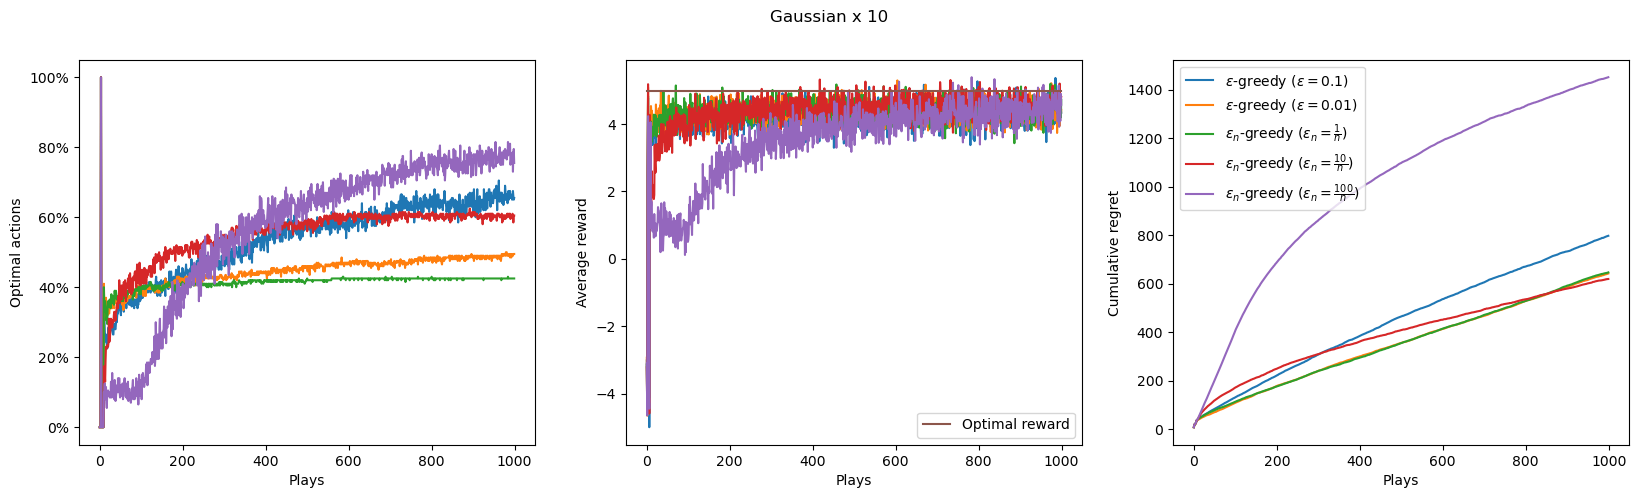

In [24]:
bench_kwargs = {
    "n_rounds": 1000,
    "n_runs": 200,
    "threads": 10,
}

def f1n(n):
    return 1/n

def f10n(n):
    return 10/n

def f100n(n):
    return 100/n

agents = [
    EpsilonGreedy(10, 0.1),
    EpsilonGreedy(10, 0.01),
    EpsilonGreedy(10, f1n),
    EpsilonGreedy(10, f10n),
    EpsilonGreedy(10, f100n),
]

labels = [
    r"$\varepsilon$-greedy ($\varepsilon = 0.1$)",
    r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{1}{n}$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{10}{n}$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{100}{n}$)",
]

for mab, title in test_mabs:
    fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
    fig.suptitle(title)
    plt.show()

**Выводы:**

1. Как и в случае с $\varepsilon$-жадными стратегиями, результативность $\varepsilon_n$-жадных стратегий на конечном интервале времени зависит от выбора $\varepsilon_n$. Даже если ограничиться $\varepsilon_n \propto \frac1n$, то выбор коэффициента пропорциональность всё ещё играет роль.
2. Судя по экспериментам можно предположить, что **чем труднее отличить ручки бандитов, тем больше нужно делать исследований**, т.е. тем лучше себя показывают ($\varepsilon$-) и $\varepsilon_n$-жадные стратегии с бóльшими $\varepsilon$ и $\varepsilon_n$ соответственно. Не формально, под «трудностью в различии» ручек бандитов имеется ввиду разность между ожиданием выигрыша оптимальной и субоптимальных ручек по отношению к дисперсии распределений наград.
3. $\varepsilon$-Жадные стратегии, уделяющие много времени исследованиям на ранних этапах, теряют значительную часть суммарной награды, дёргая за ручки с низкими ожидаемыми наградами. Поскольку исследовние делается равномерно, то на каждом из шагов вероятность дёрнуть за топ-2 ручку (с точки зрения текущих оценок) такая же, как и для топ-$M$ ручки — $\frac{\varepsilon}{M}$.

Таким образом, нужна стратегия, которая будет делать исследования не равномерно, а в соответствии с текущими оценками ожидаемых наград. Возможным решением могут быть, так называемые, UCB-стратегии, опирающиеся на upper confidence bound (UCB).

## UCB

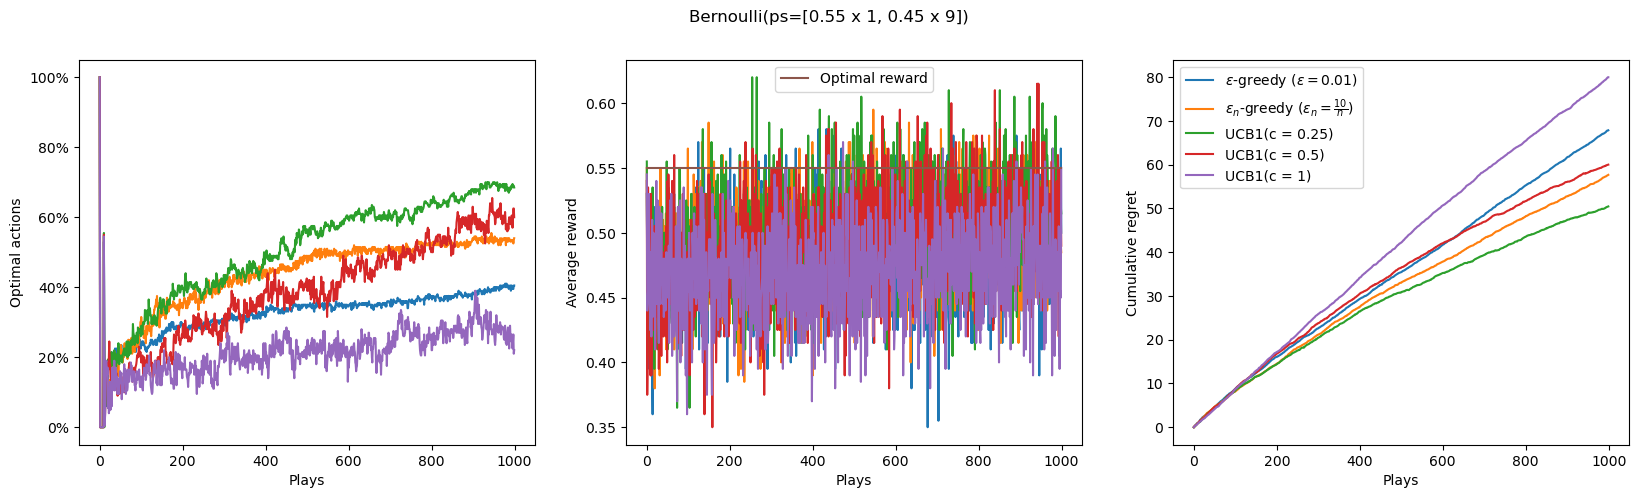

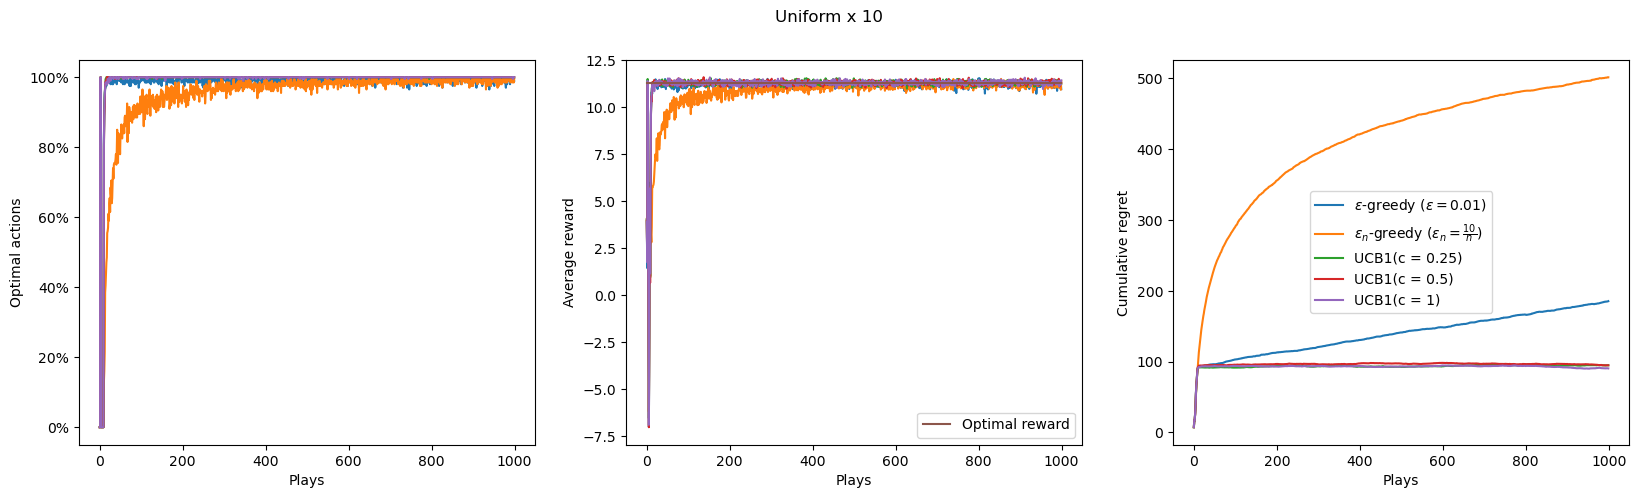

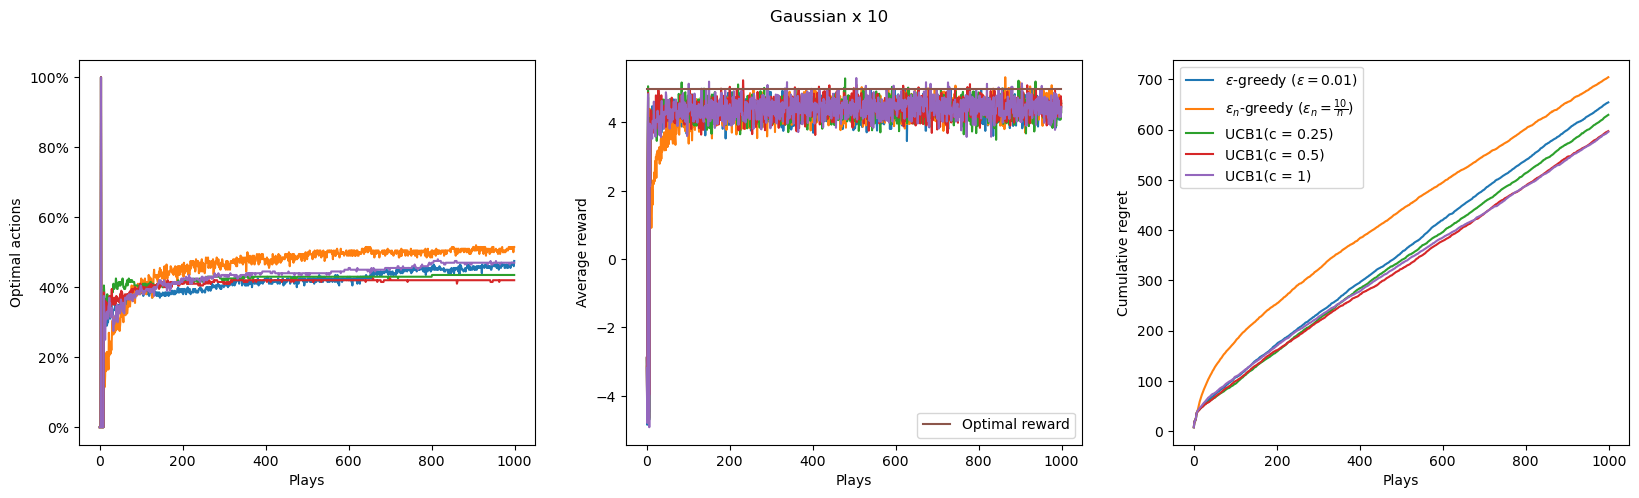

In [25]:
from agent import UCB1


bench_kwargs = {
    "n_rounds": 1000,
    "n_runs": 200,
    "threads": 10,
}

def f10n(n):
    return 10/n

agents = [
    EpsilonGreedy(10, 0.01),
    EpsilonGreedy(10, f10n),
    UCB1(10, 0.25),
    UCB1(10, 0.5),
    UCB1(10, 1.0),
]

labels = [
    r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
    r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{10}{n}$)",
    "UCB1(c = 0.25)",
    "UCB1(c = 0.5)",
    "UCB1(c = 1)",
]

for mab, title in test_mabs:
    fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
    fig.suptitle(title)
    plt.show()

In [26]:
# bench_kwargs = {
#     "n_rounds": 10000,
#     "n_runs": 100,
#     "threads": 10,
# }

# def f10n(n):
#     return 10/n

# agents = [
#     EpsilonGreedy(10, 0.01),
#     EpsilonGreedy(10, f10n),
#     UCB1(10, 0.25),
#     UCB1(10, 0.5),
#     UCB1(10, 1.0),
# ]

# labels = [
#     r"$\varepsilon$-greedy ($\varepsilon = 0.01$)",
#     r"$\varepsilon_n$-greedy ($\varepsilon_n = \frac{10}{n}$)",
#     "UCB1(c = 0.25)",
#     "UCB1(c = 0.5)",
#     "UCB1(c = 1)",
# ]

# for mab, title in (test_mabs[:2] + test_mabs[3:]):
#     fig, axs = plot_performance_results([get_average_performance(mab, ag, **bench_kwargs) for ag in agents], labels)
#     fig.suptitle(title)
#     plt.show()

# Work in progress...

### Теорема о UCB1

### Thompson sampling

Сравнение стратегий с помощью parameter study (см. Figure 2.6 в Sutton, Barto)

## Нестационарные бандиты

схема обновления оценок

## Более сложные бандиты

- Экспоненциальные. Коши

Сравнение для бандитов с одинаковыми ожиданием и дисперсией, но разными распределениями
- ожидание у всех по нулю
- ожидание у всех 1

Adversarial-bandits, которые меняют свои выигрыши в соответствии с действиями игрока